<a href="https://colab.research.google.com/github/dimakpa/DL_Projects/blob/main/TestNewDataResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Все библиотеки для удобства

In [32]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from pathlib import Path
import os
from time import time
from tqdm import tqdm
import numpy

import torch
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision.transforms import transforms

# specify GPU
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Трансформер

In [33]:
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Создадим DF для результатов

Спарсим числа всез файлов

In [35]:
data = []
import os

directory = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/new_data/'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
      data.append(filename[:-4])
data

['101_cross',
 '103_long',
 '101_long',
 '114_long',
 '37_long',
 '140_long',
 '143_long',
 '67_cross',
 '61_cross',
 '72_long',
 '71_cross',
 '73_cross',
 '77_cross',
 '80_cross',
 '87_cross',
 '88_cross',
 '80_long',
 '94_cross',
 '90_long',
 '94_long']

Создадим ДФ

In [36]:
df = pd.DataFrame(data=data, columns = ['id'])
df['pred'] = 0
df.head()


,id,pred
0,101_cross,0
1,103_long,0
2,101_long,0
3,114_long,0
4,37_long,0


Спарсим new_data каждое 5 изображение tif

In [37]:
from PIL import Image
im = Image.open('/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/new_data/37_long.tif')
im.show()

In [38]:
def parse_tif(filePath, fileSave, numOfBlock):
    if Path(filePath).is_file():
      img = Image.open(filePath)
      numFramesPerTif = img.n_frames
      for i in range (numFramesPerTif):
          if i%5 == 0:
              try:
                  img.seek(i)
                  img.save(fileSave + numOfBlock +'_%s.jpg'%(i,))
              except EOFError: #end of file error
                  print('End of file error')


In [39]:
import os
save_path = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/new_data_test/'

directory = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/new_data/'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        parse_tif(f, save_path, filename[:-4])

Теперь имеем распарщеные изображения
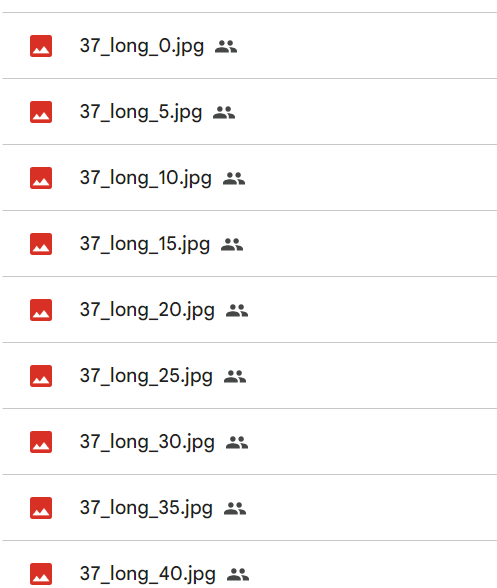

для каждого id найдем его фото, получим результат (1 или 0) и посмотрим среднее арифметическое. Напишем функции для этого


Предикт для листа

In [40]:
def get_pred(list_of_preds):
  k=0
  for i in list_of_preds:
    k+=i
  return k/len(list_of_preds)

Проерка работы функции

In [41]:
lst = [0, 1, 1, 1, 0, 0, 1, 0, 1]
get_pred(lst)

0.5555555555555556

Загрузим нашу модельку

In [42]:
from torchvision.models import resnet18
from torch.nn import Linear, CrossEntropyLoss

model = resnet18(pretrained=True)
model.fc = Linear(in_features=512, out_features=2)
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/MEPHI/ResNet/model.pth'))
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [43]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [44]:
sample_1 = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/new_data_test/37_long_0.jpg'

sample_list = [sample_1]

Создадим функцию, которая составляет список сэмплов для каждого id, ищет предикты, создает список предиктов и возращает predict


Функция возвращает ссылки по id

In [45]:
def get_samples(id_str):
    samples = []
    directory = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/new_data_test/'
    for filename in os.listdir(directory):
        if(filename[:-6] == id_str or filename[:-7] == id_str): #Проверяем на сходство с id
          f = os.path.join(directory, filename)
          if os.path.isfile(f):
            samples.append(f)
    return samples

Как работает функция. Посмотрим ссылки по id

In [46]:
get_samples('37_long')

['/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/new_data_test/37_long_0.jpg',
 '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/new_data_test/37_long_5.jpg',
 '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/new_data_test/37_long_10.jpg',
 '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/new_data_test/37_long_15.jpg',
 '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/new_data_test/37_long_20.jpg',
 '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/new_data_test/37_long_25.jpg',
 '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/new_data_test/37_long_30.jpg',
 '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/new_data_test/37_long_35.jpg',
 '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/new_data_test/37_long_40.jpg',
 '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/new_data_test/37_long_45.jpg',
 '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/new_data_test/37_long_50.jpg',
 '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/new_data_test

функция возвращает лист предиктов по сэмплам


In [47]:
from PIL import Image
import numpy as np
def get_pred_from_samples(sample_list):
  preds = []
  for image_path in sample_list:
      img = pil_loader(image_path)
      # display(img.resize((224,224)))
      img_tensor = tfm(img)
      img_tensor = img_tensor[np.newaxis, :]
      img_tensor = img_tensor.to(device)
      pred_prob = model(img_tensor)
      pred = torch.max(pred_prob,1).indices
      pred = pred.item()
      preds.append(pred)
  return preds


предикт каждой ссылки по id

In [48]:
get_pred_from_samples(get_samples('101_long'))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Считаем pred листа

In [49]:
get_pred(get_pred_from_samples(get_samples('37_long')))

0.8666666666666667

In [50]:
for index, row in df.iterrows ():
 df.loc[index, 'pred'] = get_pred(get_pred_from_samples(get_samples(row['id'])))
df.head()

,id,pred
0,101_cross,0.500000
1,103_long,0.285714
2,101_long,1.000000
3,114_long,0.000000
4,37_long,0.866667


In [51]:
df

,id,pred
0,101_cross,0.500000
1,103_long,0.285714
2,101_long,1.000000
3,114_long,0.000000
4,37_long,0.866667
5,140_long,0.000000
6,143_long,0.000000
7,67_cross,0.000000
8,61_cross,0.000000
9,72_long,0.916667


Сохраним df как csv

In [52]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/res_of_new_data.csv', index=False)

In [55]:
sample_1 = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/output/val/one/179Block_5.jpg'
sample_2 = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/output/val/one/186Block_115.jpg'
sample_3 = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/output/val/zero/193Block_65.jpg'
sample_4 = '/content/drive/MyDrive/Colab Notebooks/MEPHI/ResNet/output/val/zero/199Block_30.jpg'

sample_list = [sample_1,sample_2,sample_3,sample_4]

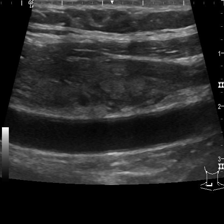

Model prediction 0, 0


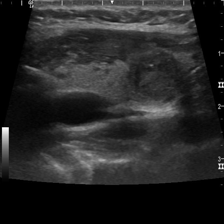

Model prediction 0, 0


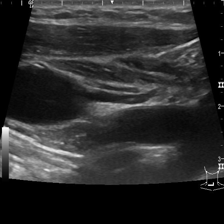

Model prediction 1, 1


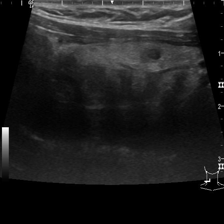

Model prediction 1, 1


In [56]:
from PIL import Image
import numpy as np

for image_path in sample_list:
    img = pil_loader(image_path)
    display(img.resize((224,224)))
    img_tensor = tfm(img)
    img_tensor = img_tensor[np.newaxis, :]
    img_tensor = img_tensor.to(device)
    pred_prob = model(img_tensor)
    pred = torch.max(pred_prob,1).indices
    pred = pred.item()
    if pred == 1:
        print(f"Model prediction {pred}, 1")
    else:
        print(f"Model prediction {pred}, 0")

    print("========================================================")